In [1]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 44.3 MB/s eta 0:00:00


In [2]:
SEED = 42

import string

import nltk
import re

import numpy as np
import pandas as pd
from pyvi import ViTokenizer

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from scipy.spatial import distance

from matplotlib import pyplot as plt

In [3]:
import os
# dir = '/content/drive/MyDrive/NLP/dữ liệu chatbot - dự án cuối kì'
dir = '../input/chatbot-data/chatbot'

filenames = os.listdir(dir)
print(filenames)

['shoping.txt', 'a ch.txt', 'tn gu.txt', 'bn b.txt', 'tdtu.txt', 's thch.txt', 'thng tin c nhn.txt', 'hc tp.txt', 'ngh nghip.txt', 'ngi yu.txt', 'gii tr.txt', 'tr chuyn v i n.txt', 'gia nh.txt', 'cc cu hi phc tp.txt', 'du lch.txt', 't nc.txt', 'robot.txt', 'ngh l.txt']


In [4]:
Q = []
A = []
for i in filenames:
    with open(dir+'/'+i, encoding="utf8") as f:
        for line in f:
            a =  line.split('__eou__')
            Q.append(a[0].strip())
            A.append(a[1].strip())
print('Number of QA pairs:', len(Q), '\n')

# shuffle to mix the data topic
QA = pd.DataFrame(zip(Q, A))
QA = QA.sample(frac=1, random_state=61)

Q = QA.iloc[:, 0].values
A = QA.iloc[:, 1].values

for i in range(5):
    print('Q:', Q[i])
    print('A:', A[i], '\n')

Number of QA pairs: 5855 

Q: có loại nào đặc biệt không bạn ?
A: có 2 loại đặc biệt nha bạn 

Q: Ê mày tao định mua son nè mày thấy chỗ nào bán được không?
A: à mày qua moon shop quận 7 thử 

Q: cho tôi hỏi nhà này có bao nhiêu phòng?
A: ngồi nhà này có đến 5 phòng nha bạn 

Q: Đặc sản của quê bạn là gì?
A: Về trái cây thì có thanh long, Về thức ăn thì có bánh căn 1 loại bánh như bánh xèo nhưng nhỏ hơn. 

Q: vậy còn số điện thoại của cậu là bao nhiêu?
A: số điện thoại của tớ là 0234567891 



In [5]:
def normalize(data):
    cleaned_data = []
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    for sent in data:
        sent = regex.sub('', sent)
        sent = ViTokenizer.tokenize(sent)
        cleaned_data.append(sent.lower())
    return cleaned_data

In [6]:
questions = normalize(Q)
answers = normalize(A)

for i in range(5):
    print('Q:', questions[i])
    print('A:', answers[i], '\n')

Q: có loại nào đặc_biệt không bạn
A: có 2 loại đặc_biệt nha bạn 

Q: ê mày tao định mua son nè mày thấy chỗ nào bán được không
A: à mày qua moon shop quận 7 thử 

Q: cho tôi hỏi nhà này có bao_nhiêu phòng
A: ngồi nhà này có đến 5 phòng nha bạn 

Q: đặc_sản của quê bạn là gì
A: về trái_cây thì có thanh_long về thức_ăn thì có bánh căn 1 loại bánh như bánh_xèo nhưng nhỏ hơn 

Q: vậy còn số điện_thoại của cậu là bao_nhiêu
A: số điện_thoại của tớ là 0234567891 



In [7]:
X_train, X_test, y_train, y_test = train_test_split(questions, answers, test_size=0.1, random_state=SEED)

In [8]:
# start and end of string token to each answer
for i in range(len(y_train)):
    y_train[i] = '<start> ' + y_train[i] + ' <end>'

In [9]:
# count each token appearing time
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train + X_test + y_train + y_test + ['<unk>'])
VOCAB_SIZE = len(tokenizer.word_index) + 1 # padding token for embedding layer later
print('VOCAB SIZE: {}'.format(VOCAB_SIZE))
vocab = list(tokenizer.word_index.keys()) # list of tokens

VOCAB SIZE: 5154


In [10]:
tokenized_questions = tokenizer.texts_to_sequences(X_train)
tokenized_answers = tokenizer.texts_to_sequences(y_train)

In [11]:
MAXLEN_QUESTION = max([len(x) for x in tokenized_questions])
padded_questions = pad_sequences(tokenized_questions, maxlen=MAXLEN_QUESTION, padding='post')
encoder_input_data = np.array(padded_questions)
print('Encoder input data shape:', encoder_input_data.shape)
print('Max length of encoder input data:', MAXLEN_QUESTION)

Encoder input data shape: (5269, 75)
Max length of encoder input data: 75


In [12]:
MAXLEN_ANSWER = max([len(x) for x in tokenized_answers])
padded_answers = pad_sequences(tokenized_answers, maxlen=MAXLEN_ANSWER, padding='post')
decoder_input_data = np.array(padded_answers)
print('Decoder input data shape:', decoder_input_data.shape)
print('Max length of decoder input data:', MAXLEN_ANSWER)

Decoder input data shape: (5269, 113)
Max length of decoder input data: 113


In [13]:
padded_answers_dec_out = pad_sequences(padded_answers[:, 1:], maxlen=MAXLEN_ANSWER, padding='post')
decoder_output_data = to_categorical(padded_answers_dec_out, VOCAB_SIZE, dtype='uint8')# remove <start> tag in answers data
print('Decoder ouput data shape:', decoder_output_data.shape)

Decoder ouput data shape: (5269, 113, 5154)


In [14]:
encoder_inputs = Input(shape=(MAXLEN_QUESTION,))
encoder_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True) (encoder_inputs) # mask zero to acknowledge 0 padding
_, state_h, state_c = LSTM(200, return_state=True) (encoder_embedding) # return last hidden and cell state
encoder_states = [state_h, state_c]

2022-06-06 22:46:47.032769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 22:46:47.156967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 22:46:47.157767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 22:46:47.158930: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
decoder_inputs = Input(shape=(MAXLEN_ANSWER,))
decoder_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True) (decoder_inputs)
decoder_lstm = LSTM(200, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states) # passing hidden states to dense
decoder_dense = Dense(VOCAB_SIZE, activation='softmax')
output = decoder_dense(decoder_outputs)

Model: "model"
____________________________________________________________________________________________________
Layer (type)               Output Shape                                  Param #   Connected to     
input_1 (InputLayer)       [(None, 75)]                                  0                          
____________________________________________________________________________________________________
input_2 (InputLayer)       [(None, 113)]                                 0                          
____________________________________________________________________________________________________
embedding (Embedding)      (None, 75, 200)                               1030800   input_1[0][0]    
____________________________________________________________________________________________________
embedding_1 (Embedding)    (None, 113, 200)                              1030800   input_2[0][0]    
____________________________________________________________________________

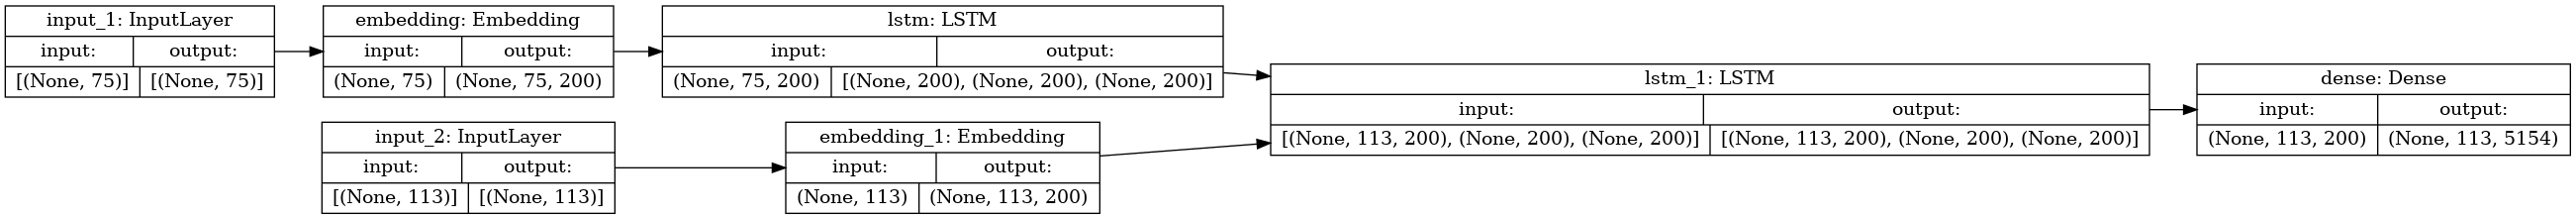

In [16]:
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary(line_length=100, positions=[.27, .73, .83, 1.]))
plot_model(model, rankdir='LR', show_shapes=True)

In [17]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=100, validation_split=0.1) # epochs >= 10 to get proper answer

2022-06-06 22:46:52.471126: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2761750284 exceeds 10% of free system memory.
2022-06-06 22:46:55.419589: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2761750284 exceeds 10% of free system memory.
2022-06-06 22:46:57.452512: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-06 22:47:04.099173: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


149/149 [==============================] - 20s 76ms/step - loss: 0.4876 - accuracy: 0.1690 - val_loss: 0.4274 - val_accuracy: 0.2449
Epoch 2/100
149/149 [==============================] - 9s 60ms/step - loss: 0.4153 - accuracy: 0.2508 - val_loss: 0.4203 - val_accuracy: 0.2481
Epoch 3/100
149/149 [==============================] - 8s 57ms/step - loss: 0.4034 - accuracy: 0.2547 - val_loss: 0.4148 - val_accuracy: 0.2517
Epoch 4/100
149/149 [==============================] - 8s 56ms/step - loss: 0.3920 - accuracy: 0.2657 - val_loss: 0.4092 - val_accuracy: 0.2643
Epoch 5/100
149/149 [==============================] - 9s 57ms/step - loss: 0.3818 - accuracy: 0.2710 - val_loss: 0.4063 - val_accuracy: 0.2637
Epoch 6/100
149/149 [==============================] - 9s 60ms/step - loss: 0.3727 - accuracy: 0.2736 - val_loss: 0.4035 - val_accuracy: 0.2652
Epoch 7/100
149/149 [==============================] - 8s 57ms/step - loss: 0.3639 - accuracy: 0.2789 - val_loss: 0.4010 - val_accuracy: 0.2703
Epo

In [18]:
def make_inference_models():
    
    # encoder model takes questions as input and output its LSTM state
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # decoder takes encoder output states as its initial state 
    # and 200 is the output of encoder last hidden and cell states dimension
    decoder_state_input_h = Input(shape=(200,))
    decoder_state_input_c = Input(shape=(200,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    # use these pre-trained layers of the model: decoder_embedding, decoder_lstm, decoder_dense 
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # decoder model takes one token and the states predicted from enc_model   
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    return encoder_model, decoder_model

enc_model, dec_model = make_inference_models()
enc_model.save('enc_model.h5')
dec_model.save('dec_model.h5')

In [19]:
# # load model
# enc_model = load_model('./../input/chatbot-data/enc_model.h5')
# dec_model = load_model('../input/chatbot-data/dec_model.h5')

In [20]:
def format_question(sent:str):
    sent = normalize([sent])[0]
    words = sent.split()
    token_list = []
    for word in words:
        try:
            index = tokenizer.word_index[word]
        except KeyError:
            index = tokenizer.word_index['<unk>']
        token_list.append(index)
    return pad_sequences([token_list], maxlen=MAXLEN_QUESTION, padding='post', truncating='post')

In [21]:
def ask(question, display=True):
    if display == True: print('Q:', question)
    question = format_question(question)
    states_values = enc_model.predict(question)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']
    
    stop_condition = False
    decoded_seq = ''
    while not stop_condition:
        # dec_outputs return a one hot vector with the dimension number of vocab size
        dec_outputs, h, c = dec_model.predict([target_seq] + states_values)
        gen_word_index = np.argmax(dec_outputs[0, -1])
        try:
            gen_word = tokenizer.index_word[gen_word_index]
        except KeyError:
            gen_word = '<end>'
        if gen_word == '<end>' or len(decoded_seq.split()) > MAXLEN_ANSWER:
            stop_condition = True
        else:
            decoded_seq += gen_word + ' '
            
        target_seq = np.zeros((1, 1))  
        target_seq[0, 0] = gen_word_index
        states_values = [h, c]
    if display == True:
        if len(decoded_seq) > 1: # empty or <2 character answer
            answer = decoded_seq[0].upper() + decoded_seq[1:].replace('_', ' ')
        else:
            answer = decoded_seq
        print('A:', answer.strip(), '\n')
    else:
        answer = decoded_seq.strip()
        return answer


In [22]:
ask('Bạn sinh năm bao nhiêu?')
ask('Có người yêu chưa?')
ask('Shop tư vấn cho mình một số mẫu giày thích hợp để đi chơi được không?')
ask('Quê bạn ở đâu?')
ask('Bạn thường làm gì trong thời gian rảnh?')
ask('Bạn có muốn đi xem phim vào cuối tuần này hay không?')
ask('Bạn thích môn thể thao gì?')

Q: Bạn sinh năm bao nhiêu?
A: Mình sinh năm 2001 

Q: Có người yêu chưa?
A: Chưa 

Q: Shop tư vấn cho mình một số mẫu giày thích hợp để đi chơi được không?
A: Bạn có thể tham khảo vài đôi giày của adidas hoặc nike 

Q: Quê bạn ở đâu?
A: Quê mình ở tiền giang 

Q: Bạn thường làm gì trong thời gian rảnh?
A: Ngủ 

Q: Bạn có muốn đi xem phim vào cuối tuần này hay không?
A: Không mình sẽ đi chắc hay đi xem phim 

Q: Bạn thích môn thể thao gì?
A: Mình thích đá bóng 



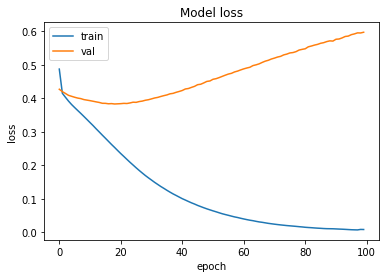

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

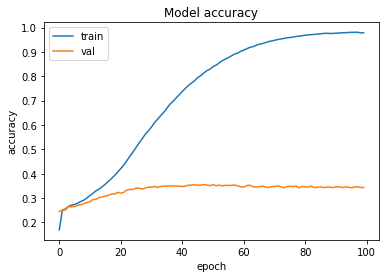

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [25]:
modelw2v = Word2Vec(sentences=[x.split() for x in answers + questions + ['<unk>']], vector_size=100, min_count=1, sg=1)

#Tính trung bình cộng các vector của từng từ trong câu
def avg_sentence_vector(sent):
    feature_vec = np.zeros((100,))
    nwords = 0
    for word in sent.split():
        if word in modelw2v.wv.index_to_key:
            try:
                word_vec = modelw2v.wv[word]
                nwords += 1
            except KeyError:
                word_vec = modelw2v.wv['<unk>']
            feature_vec = np.add(feature_vec, word_vec)
    if nwords > 0:
        feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

In [26]:
def evaluate(preds, actuals):
    similarities = []
    for i in range(len(preds)):
        pred = avg_sentence_vector(preds[i])
        actual = avg_sentence_vector(actuals[i])
        sim = np.dot(pred, actual) / (np.linalg.norm(pred) * np.linalg.norm(actual)) #distance.cosine(pred, actual)

        if not np.isnan(sim):
            similarities.append(sim)
    return np.sum(similarities)/len(similarities)

In [27]:
preds = [ask(x, display=False) for x in X_test]

In [28]:
print('Score base on semantic similarity: ', evaluate(preds, y_test))

Score base on semantic similarity:  0.9382172712226284


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
